# Анализ траекторий дифференцировки нормобластов




Установка необходимых пакетов

In [1]:
!pip install scanpy[leiden] scrublet scFates scvelo harmonypy symphonypy bbknn

!Rscript -e 'install.packages("mgcv")'


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 67.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.7/421.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.8/196.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/

In [2]:
!pip install python-igraph louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scanpy.external as sce
import loompy
import scipy.optimize
import glob
import scFates as scf

sns.set_style("ticks")
sc.settings.verbosity = 3

Скачиваем данные и читаем данные

In [4]:
!gdown '118dVUszFtugVm-UqZaVrY6zqPwVYsCkT'

Downloading...
From: https://drive.google.com/uc?id=118dVUszFtugVm-UqZaVrY6zqPwVYsCkT
To: /content/adata.h5ad
100% 79.3M/79.3M [00:00<00:00, 228MB/s]


In [5]:
adata = sc.read_h5ad("adata.h5ad")


Делаем названия генов уникалььными

In [6]:
adata.var_names_make_unique()

Посмотрим на данные

In [7]:
adata.obs

cell_type
CTATCCGGTGTCCGGT-1-s1d3            CD14+ Mono
AGAAGCGGTGTCTTAG-1-s1d3          CD8+ T naive
GGCTTGGTCTACGCAA-1-s1d3                    NK
AGAAGTATCTAAGCCA-1-s1d3          CD8+ T naive
GAACGTTTCCTACGAA-1-s1d3                 T reg
...                                       ...
AACAAAGGTTGGTACT-1-s1d3          CD8+ T naive
TGACAGTCATGGCTGC-1-s1d3  CD8+ T CD57+ CD45RA+
CTGGCAGGTCTCACGG-1-s1d3          CD8+ T naive
GTAACCATCGGAGTGA-1-s1d3          Reticulocyte
GAGTTGTCAGTCGGAA-1-s1d3          Reticulocyte

[6106 rows x 1 columns]

In [8]:
categories = adata.obs['cell_type'].cat.categories
print(categories)

Index(['B1 B IGKC+', 'B1 B IGKC-', 'CD4+ T CD314+ CD45RA+', 'CD4+ T activated',
       'CD4+ T activated integrinB7+', 'CD4+ T naive', 'CD8+ T CD49f+',
       'CD8+ T CD57+ CD45RA+', 'CD8+ T CD69+ CD45RA+', 'CD8+ T CD69+ CD45RO+',
       'CD8+ T TIGIT+ CD45RA+', 'CD8+ T TIGIT+ CD45RO+', 'CD8+ T naive',
       'CD14+ Mono', 'CD16+ Mono', 'Erythroblast', 'G/M prog', 'HSC', 'ILC1',
       'Lymph prog', 'MAIT', 'MK/E prog', 'NK', 'Naive CD20+ B IGKC+',
       'Naive CD20+ B IGKC-', 'Normoblast', 'Plasma cell IGKC+',
       'Proerythroblast', 'Reticulocyte', 'T reg', 'Transitional B', 'cDC2',
       'dnT', 'gdT CD158b+', 'gdT TCRVD2+', 'pDC'],
      dtype='object')


Промаркируем митохондриальные гены

In [9]:
adata.var["mt"] = adata.var.index.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    inplace=True,
    log1p=False,
)

Посмотрим на данные

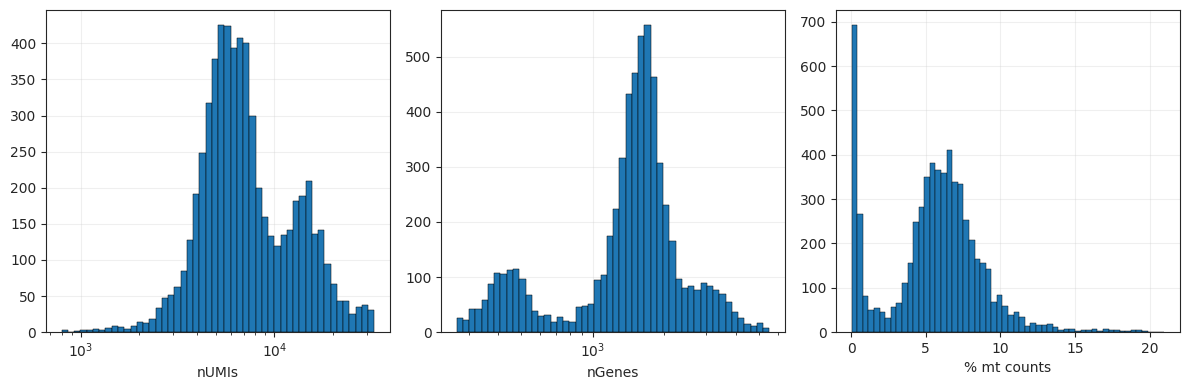

In [10]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

sns.histplot(adata.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

sns.histplot(adata.obs.pct_counts_mt, alpha=1, edgecolor="black", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("% mt counts")
axes[2].grid(alpha=0.3)

fig.tight_layout()

Сделаем фильтрацию даннных

In [11]:


adata = adata[
    (adata.obs.total_counts >= 2000) &
    (adata.obs.n_genes_by_counts >= 900) &
    (adata.obs.pct_counts_mt <= 20)
].copy()

Удалим дуплеты

In [12]:
sc.pp.scrublet(adata)
adata = adata[adata.obs.doublet_score <= 0.2].copy()

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 16.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%
    Scrublet finished (0:01:45)


Нормализуем данные

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [14]:
adata.raw = adata

Ещё раз посмотрим на данные

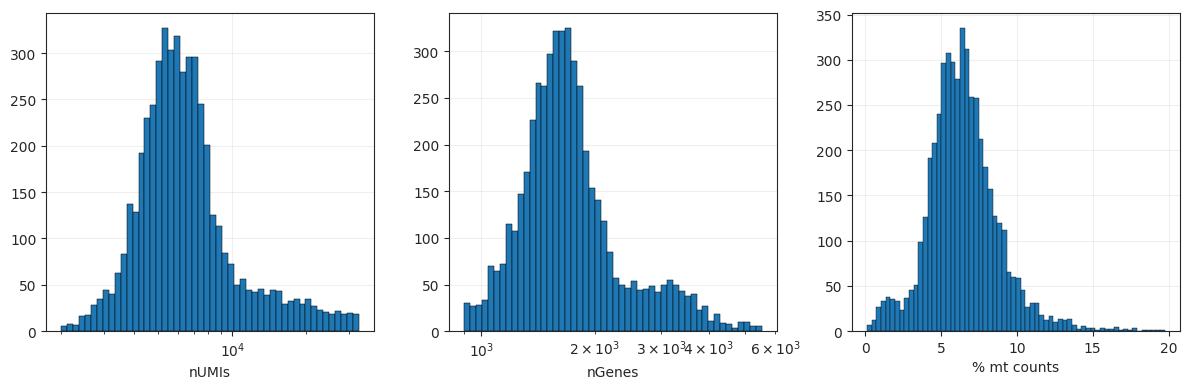

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

sns.histplot(adata.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

sns.histplot(adata.obs.pct_counts_mt, alpha=1, edgecolor="black", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("% mt counts")
axes[2].grid(alpha=0.3)

fig.tight_layout()

Возьмём 3000 наиболее экспрессируемых генов

In [16]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
adata = adata[:, adata.var.highly_variable].copy()

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [17]:
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, n_comps=20)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=20
    finished (0:00:01)


Построим UMAP

In [18]:
# UMAP and clustering

sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)
running Leiden clustering


<ipython-input-18-d774761b6e15>:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


running Leiden clustering
    finished: found 27 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


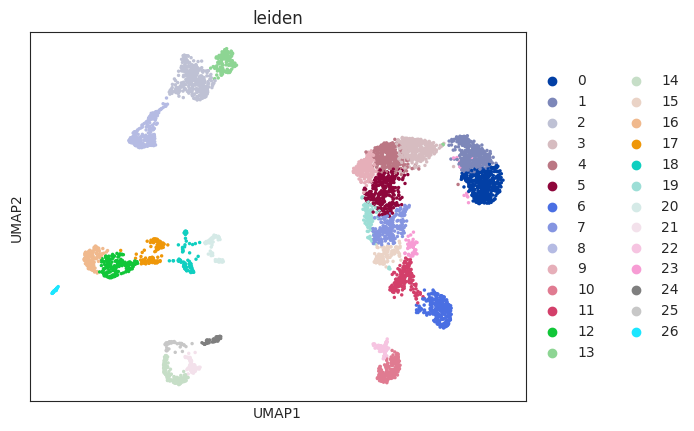

In [19]:
# Plotting of UMAP
sc.tl.leiden(adata, resolution=2)
sc.pl.umap(adata, color='leiden')


Проведём batch-коррекцию

In [20]:
sce.pp.harmony_integrate(adata, key="cell_type", max_iter_harmony=30)
sc.pp.neighbors(adata, use_rep="X_pca_harmony")
sc.tl.umap(adata)

2024-12-20 09:21:05,863 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2024-12-20 09:21:08,112 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2024-12-20 09:21:08,172 - harmonypy - INFO - Iteration 1 of 30
INFO:harmonypy:Iteration 1 of 30
2024-12-20 09:21:12,530 - harmonypy - INFO - Iteration 2 of 30
INFO:harmonypy:Iteration 2 of 30
2024-12-20 09:21:16,272 - harmonypy - INFO - Iteration 3 of 30
INFO:harmonypy:Iteration 3 of 30
2024-12-20 09:21:19,590 - harmonypy - INFO - Iteration 4 of 30
INFO:harmonypy:Iteration 4 of 30
2024-12-20 09:21:21,766 - harmonypy - INFO - Iteration 5 of 30
INFO:harmonypy:Iteration 5 of 30
2024-12-20 09:21:23,932 - harmonypy - INFO - Iteration 6 of 30
INFO:harmonypy:Iteration 6 of 30
2024-12-20 09:21:26,073 - harmonypy - INFO - Iteration 7 of 30
INFO:harmonypy:Iteration 7 of 30
2024-12-20 09:21:27,544 - 

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:08)


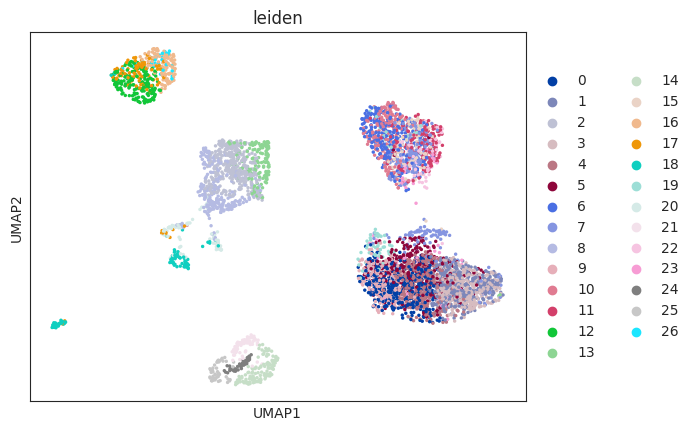

In [21]:
sc.pl.umap(adata, color="leiden")

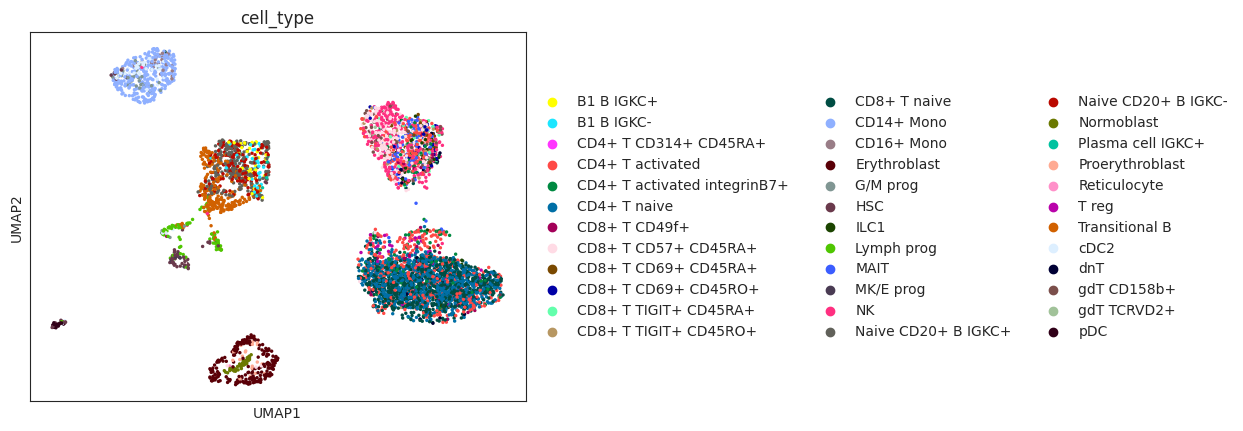

In [22]:
sc.pl.umap(adata, color="cell_type")

Отберём только эритробласты, проэритробласты и нормобласты.

In [23]:

selected_types = ['Erythroblast', 'Normoblast', 'Proerythroblast']  #
filtered_adata = adata[adata.obs['cell_type'].isin(selected_types)].copy()

print(filtered_adata.obs['cell_type'].value_counts())

filtered_adata.write("filtered_adata.h5ad")



cell_type
Erythroblast       211
Normoblast          46
Proerythroblast     21
Name: count, dtype: int64


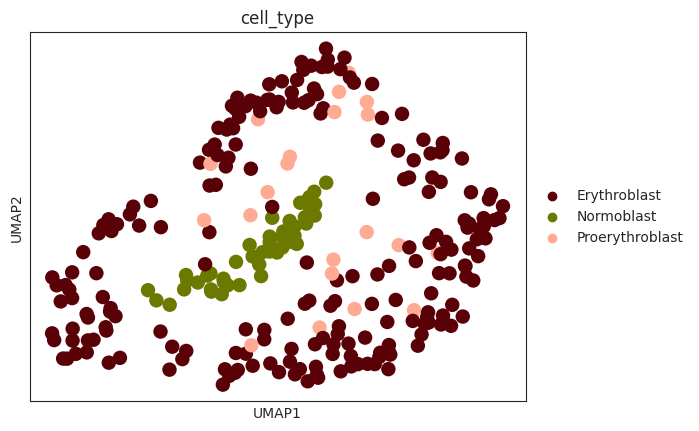

In [24]:
sc.pl.umap(filtered_adata, color="cell_type")

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


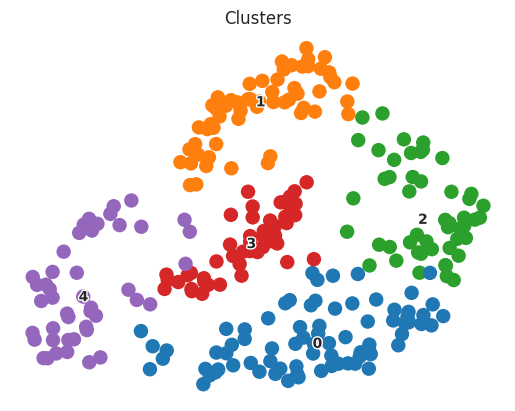

In [25]:
sc.tl.leiden(filtered_adata, resolution=0.3)
sc.pl.umap(filtered_adata, color="leiden", legend_loc="on data", legend_fontoutline=2,
           frameon=False, title="Clusters")

Посмотрим на наиболее экспрессирумые гены для каждого типа клеток

In [26]:
sc.tl.rank_genes_groups(filtered_adata, groupby="cell_type")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [27]:
sc.get.rank_genes_groups_df(filtered_adata, group="Erythroblast")

names     scores  logfoldchanges         pvals     pvals_adj
0      NUSAP1  15.984032        3.450892  5.428656e-31  7.574604e-27
1       HMGB2  13.059978        2.870844  1.083654e-20  3.780055e-17
2        TMPO  12.205341        2.638949  2.050254e-21  9.535730e-18
3      TUBA1B  11.688743        2.838631  1.678837e-18  1.281373e-15
4      TUBB4B  11.633286        2.322421  3.107279e-20  6.533738e-17
...       ...        ...             ...           ...           ...
13948    YBX3  -5.908751       -0.668715  4.690251e-08  3.537464e-06
13949   UBE2H  -6.158289       -2.344388  3.343962e-08  2.606609e-06
13950    EMC3  -6.475193       -1.236017  4.456725e-09  4.118191e-07
13951   REXO2  -6.792801       -2.323767  2.176340e-09  2.246622e-07
13952  BNIP3L  -7.325375       -1.764778  1.742157e-10  2.360030e-08

[13953 rows x 5 columns]

In [28]:
df1= sc.get.rank_genes_groups_df(filtered_adata, group="Erythroblast")
a = df1[(df1.logfoldchanges > 2) & (df1.pvals_adj <= 1e-12)]
df1[(df1.logfoldchanges > 2) & (df1.pvals_adj <= 1e-12)]


names     scores  logfoldchanges         pvals     pvals_adj
0      NUSAP1  15.984032        3.450892  5.428656e-31  7.574604e-27
1       HMGB2  13.059978        2.870844  1.083654e-20  3.780055e-17
2        TMPO  12.205341        2.638949  2.050254e-21  9.535730e-18
3      TUBA1B  11.688743        2.838631  1.678837e-18  1.281373e-15
4      TUBB4B  11.633286        2.322421  3.107279e-20  6.533738e-17
6       KIF11  11.276899        3.034217  4.457177e-24  3.109550e-20
7       MKI67  11.101944        2.720776  1.947616e-20  5.435017e-17
8       UBE2S  10.916517        2.390108  1.433997e-19  1.667380e-16
9        TUBB  10.761052        2.590060  1.219184e-17  7.396207e-15
10       BTG3  10.651845        2.732604  3.659068e-20  6.533738e-17
11       SMC4  10.482152        2.392147  3.668862e-19  3.656545e-16
12       TPX2  10.448955        2.679221  3.746141e-20  6.533738e-17
13     DLGAP5  10.229108        2.694532  8.583989e-20  1.197724e-16
14       CDK1  10.229080        2.596112  1.852503e-19  1.988306e-16
15      UBE2T  10.159825        2.565991  1.744864e-18  1.281373e-15
16        RDX   9.998955        2.494821  2.444944e-18  1.705715e-15
17       MXD3   9.971574        4.060627  1.245293e-19  1.579597e-16
18        DCK   9.881105        2.060231  3.733332e-17  2.083647e-14
19      CKAP2   9.769696        2.529318  1.538386e-18  1.262653e-15
20      CDKN3   9.745904        2.369816  6.482082e-18  4.111113e-15
22       NUF2   9.494573        2.868700  1.384496e-18  1.207367e-15
23       SGO2   9.469469        3.542233  1.357587e-18  1.207367e-15
24  HIST1H2BK   9.468545        4.913792  2.982150e-18  1.981426e-15
25      CENPF   9.456132        2.366848  5.410901e-17  2.603390e-14
28       SMC2   9.231187        2.148831  1.116311e-15  4.098916e-13
29       KNL1   9.203250        2.719391  2.035865e-17  1.183601e-14
31      FBXO5   9.103901        2.741755  9.023734e-17  4.196939e-14
32   HIST1H3F   9.073427        2.988788  4.222590e-17  2.266069e-14
33      CENPA   9.051285        5.283995  4.938001e-17  2.551849e-14
35   HIST1H3B   9.013936        2.728237  3.110593e-16  1.315215e-13
36   HIST2H4B   8.969499        2.969874  5.260660e-17  2.603390e-14
37     CDKN2D   8.925234        2.380851  2.995949e-16  1.306327e-13
39      CCNA2   8.859251        2.650344  3.767897e-16  1.502099e-13
41  HIST1H2BB   8.802899        3.229444  1.523286e-16  6.856261e-14
42   HIST1H4E   8.759598        2.497975  7.135917e-16  2.691012e-13
46       SGO1   8.485625        2.605743  2.255871e-15  8.070814e-13

In [29]:
gene_expression = pd.DataFrame(
      # Преобразование в плотную матрицу, если это необходимо
    index=filtered_adata.obs.index,  # Названия клеток (строки)
    columns=filtered_adata.var.index  # Названия генов (столбцы)
)

# Сохраните DataFrame в CSV
gene_expression.to_csv("gene_expression.txt", sep='\t')

# Сохраните аннотации клеток (obs) в текстовый файл
adata.obs.to_csv("cell_annotations.txt", sep='\t')

# Сохраните аннотации генов (var) в текстовый файл
adata.var.to_csv("gene_annotations.txt", sep='\t')

NameError: name 'df2' is not defined

In [33]:
sc.get.rank_genes_groups_df(filtered_adata, group="Normoblast")


names     scores  logfoldchanges          pvals     pvals_adj
0          YBX3  12.439535        1.088825   5.827283e-21  2.852915e-19
1           HBB  11.988974        0.624667   7.293637e-27  6.970419e-25
2          SNCA  11.309748        1.140868   4.581650e-20  2.042420e-18
3      SLC25A37  11.072948        1.100854   2.206358e-18  7.715618e-17
4        BNIP3L  10.664986        2.410381   7.787451e-15  1.807795e-13
...         ...        ...             ...            ...           ...
13948      PTMA -25.349491       -4.724836   4.564751e-50  3.538443e-47
13949     H2AFZ -25.447699       -5.654773   1.053209e-73  7.347713e-70
13950      TMPO -26.422810       -5.222471   1.298305e-58  2.542661e-55
13951      TUBB -27.229784       -4.855294   1.018569e-49  7.106047e-47
13952    NUSAP1 -37.632347      -31.724613  1.641910e-100  2.290957e-96

[13953 rows x 5 columns]

In [34]:
df2= sc.get.rank_genes_groups_df(filtered_adata, group="Normoblast")
b = df2[(df2.logfoldchanges > 2) & (df2.pvals_adj <= 1e-5)]
df2[(df2.logfoldchanges > 2) & (df2.pvals_adj <= 1e-5)]

names     scores  logfoldchanges         pvals     pvals_adj
4      BNIP3L  10.664986        2.410381  7.787451e-15  1.807795e-13
6        BPGM   9.440896        2.312685  4.500616e-13  8.509092e-12
8       UBE2H   8.825513        3.168905  1.017337e-11  1.629724e-10
10  LINC02772   8.722178        2.547257  8.710669e-12  1.405086e-10
12     TRIM58   8.007861        2.636378  1.540072e-10  2.050441e-09
21      MKRN1   7.125521        2.352345  3.827018e-09  4.231251e-08
25     GPCPD1   6.513057        2.064546  2.429311e-08  2.373682e-07
26      ARL4A   6.376166        3.110792  7.335690e-08  6.650740e-07
27      RSAD2   6.359508        3.279165  7.201864e-08  6.542162e-07
28       XPO7   6.263752        3.084966  1.026374e-07  9.086928e-07
37       GDE1   5.726591        2.741524  6.201191e-07  4.801621e-06
39     PIK3R1   5.675561        2.632731  7.579990e-07  5.785755e-06
41      TBCEL   5.636222        4.139029  9.742573e-07  7.292818e-06
43     SLFN14   5.588051        2.275950  8.437127e-07  6.384123e-06

In [35]:
sc.get.rank_genes_groups_df(filtered_adata, group="Proerythroblast")

names     scores  logfoldchanges         pvals     pvals_adj
0           RPS16  16.119957        2.626968  1.727577e-19  1.205244e-15
1           RPS27  13.827746        2.225700  1.029712e-15  2.873514e-12
2           RPL34  13.358205        2.538883  2.488834e-13  2.480478e-10
3          RPL13A  13.219481        2.990140  1.693482e-13  1.817627e-10
4           RPS15  13.187725        1.988478  5.992566e-15  1.194490e-11
...           ...        ...             ...           ...           ...
13948  AC103876.1  -8.127501      -27.718658  1.881744e-14  3.281996e-11
13949        SNCA  -8.253443       -2.040160  2.631206e-08  4.477222e-06
13950  AC100810.1  -8.411914       -2.675842  1.047567e-10  4.299028e-08
13951       OSBP2  -9.759721       -2.686233  6.114566e-11  2.752146e-08
13952        SMOX -10.294285      -27.799294  5.063285e-21  7.064801e-17

[13953 rows x 5 columns]

In [36]:
df3= sc.get.rank_genes_groups_df(filtered_adata, group="Proerythroblast")
c = df3[(df3.logfoldchanges > 1) & (df3.pvals_adj <= 1e-8)]
df3[(df3.logfoldchanges > 1) & (df3.pvals_adj <= 1e-8)]

names     scores  logfoldchanges         pvals     pvals_adj
0    RPS16  16.119957        2.626968  1.727577e-19  1.205244e-15
1    RPS27  13.827746        2.225700  1.029712e-15  2.873514e-12
2    RPL34  13.358205        2.538883  2.488834e-13  2.480478e-10
3   RPL13A  13.219481        2.990140  1.693482e-13  1.817627e-10
4    RPS15  13.187725        1.988478  5.992566e-15  1.194490e-11
5    RPL35  13.128917        2.067958  5.520190e-17  2.567441e-13
6    RPL18  12.951236        2.196689  3.054014e-14  3.873878e-11
7     RPS9  12.698699        2.564567  5.156429e-13  4.232215e-10
8   RPL36A  12.603301        2.405930  6.455927e-14  7.506629e-11
9    RPL17  12.501774        2.811758  2.358077e-12  1.566774e-09
10   RPLP2  12.451897        1.537038  8.456003e-16  2.873514e-12
11  RPS27A  12.215364        2.290318  3.269344e-13  3.041144e-10
12  EEF1A1  12.017733        2.494090  2.154411e-12  1.503025e-09
13   RPL13  11.890159        2.717301  9.398372e-13  7.285304e-10
14    RPL3  11.697327        2.895949  8.557157e-12  4.775920e-09
15  RPL18A  11.584616        2.445006  3.589955e-12  2.177854e-09
16  RPL37A  11.560009        2.866956  9.147794e-12  4.909199e-09
17    RPS3  11.358016        2.391259  2.742203e-12  1.739180e-09
18   RPLP1  11.077426        2.275630  1.768948e-12  1.299059e-09
20    PTMA  10.822788        2.003438  5.345266e-15  1.194490e-11
34   HMGB1   9.437010        1.435929  5.502922e-12  3.199261e-09
35     DUT   9.430602        1.784746  3.933096e-13  3.429906e-10

In [37]:
unique_elements_df1 = set(a["names"].unique())
unique_elements_df2 = set(b["names"].unique())
unique_elements_df3 = set(c["names"].unique())


combined_unique_elements = unique_elements_df1 | unique_elements_df2 | unique_elements_df3
print("Все уникальные элементы:", combined_unique_elements)


combined_df = pd.DataFrame({"gene_names": list(combined_unique_elements)})
print("\nОбъединённый DataFrame:")
print(combined_df)

Все уникальные элементы: {'GPCPD1', 'RPL13', 'TUBB4B', 'TUBA1B', 'HMGB2', 'PIK3R1', 'HMGB1', 'DUT', 'RPL13A', 'CCNA2', 'RPS9', 'EEF1A1', 'CDKN3', 'XPO7', 'TMPO', 'FBXO5', 'NUSAP1', 'ARL4A', 'CENPA', 'SGO1', 'RPS27A', 'UBE2T', 'BPGM', 'KIF11', 'SGO2', 'NUF2', 'KNL1', 'RPL36A', 'RPL17', 'SLFN14', 'CDK1', 'HIST1H3F', 'BTG3', 'HIST1H3B', 'MXD3', 'RPLP1', 'RPS27', 'RPL3', 'RPLP2', 'PTMA', 'TUBB', 'DLGAP5', 'CDKN2D', 'UBE2H', 'DCK', 'RSAD2', 'RPS3', 'RPL34', 'MKI67', 'HIST1H2BK', 'RPL35', 'GDE1', 'HIST1H4E', 'LINC02772', 'BNIP3L', 'TPX2', 'SMC4', 'TRIM58', 'UBE2S', 'RDX', 'RPS16', 'RPL37A', 'HIST1H2BB', 'MKRN1', 'HIST2H4B', 'TBCEL', 'RPL18A', 'RPL18', 'RPS15', 'CENPF', 'SMC2', 'CKAP2'}

Объединённый DataFrame:
   gene_names
0      GPCPD1
1       RPL13
2      TUBB4B
3      TUBA1B
4       HMGB2
..        ...
67      RPL18
68      RPS15
69      CENPF
70       SMC2
71      CKAP2

[72 rows x 1 columns]


Построим траекторию дифференцировки

inferring a principal tree --> parameters used 
    200 principal points, sigma = 1, lambda = 50, metric = euclidean
    fitting:  12%|█▏        | 6/50 [00:00<00:02, 19.53it/s]
    converged
    finished (0:00:00) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


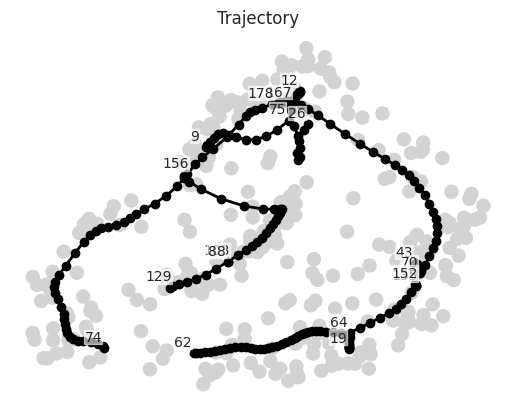

In [41]:
scf.tl.tree(filtered_adata, method="ppt", Nodes=200, use_rep="pca", device="cuda:0",
            ppt_lambda=50, ppt_sigma=1, ppt_nsteps=50)
scf.pl.graph(filtered_adata, basis="umap", frameon=False, title="Trajectory")

In [39]:
unique_elements_df1 = set(df1["names"].unique())
unique_elements_df2 = set(df2["names"].unique())
unique_elements_df3 = set(df3["names"].unique())

# 2. Объединение всех уникальных элементов
combined_unique_elements = unique_elements_df1 | unique_elements_df2 | unique_elements_df3
print("Все уникальные элементы:", combined_unique_elements)

# Преобразование в DataFrame (если нужно сохранить результат в таблице)
combined_df = pd.DataFrame({"gene_names": list(combined_unique_elements)})
print("\nОбъединённый DataFrame:")
print(combined_df)

Все уникальные элементы: {'RBBP6', 'ZNF133', 'AC211433.1', 'ECHDC1', 'OAZ2', 'AC020765.2', 'TMEM50A', 'SLC27A3', 'CRHBP', 'AL133330.1', 'NDC80', 'DRG1', 'PGAP3', 'TECPR2', 'DLC1', 'POLR2F', 'LINC02328', 'TMEM256', 'RBX1', 'LINC02175', 'MRPS2', 'CTDSPL2', 'KSR1', 'CYP51A1', 'LINC02802', 'TMEM234', 'ZDHHC3', 'IGKC', 'SAMD12', 'AP001033.2', 'ANXA5', 'C18orf54', 'ISCU', 'TRIM39', 'VPS45', 'NOTCH1', 'AC114271.1', 'LZIC', 'RPH3A', 'TAX1BP1', 'NMT2', 'EDC3', 'SLTM', 'DBF4', 'NOD2', 'RPP25', 'MDM4', 'HIST1H4E', 'RPL37', 'NT5C2', 'DNAAF2', 'ATP2B1-AS1', 'AHNAK', 'PLGRKT', 'IRF2BP2', 'CMSS1', 'GOLGA8N', 'NIPBL', 'IRGQ', 'EXTL2', 'AHCYL2', 'ZFHX2-AS1', 'GPM6A', 'GUCY1A1', 'PIP4P2', 'LAPTM4B', 'URB1-AS1', 'SYNGR1', 'COPG2', 'HLA-F', 'RAP2C-AS1', 'AC073896.2', 'C5orf51', 'C21orf62-AS1', 'CKS1B', 'KDM8', 'MRPS33', 'EMC9', 'TUSC2', 'FAM66C', 'TCTA', 'CYTL1', 'PPP1R35', 'ORC5', 'MED13L', 'AC048382.5', 'FAM72A', 'ARFGAP2', 'AC010623.1', 'C7orf26', 'CBFA2T2', 'GABARAP', 'SH2B2', 'ACP5', 'OAS2', 'CYCS', 

Аннотация датосета по маркерным генам

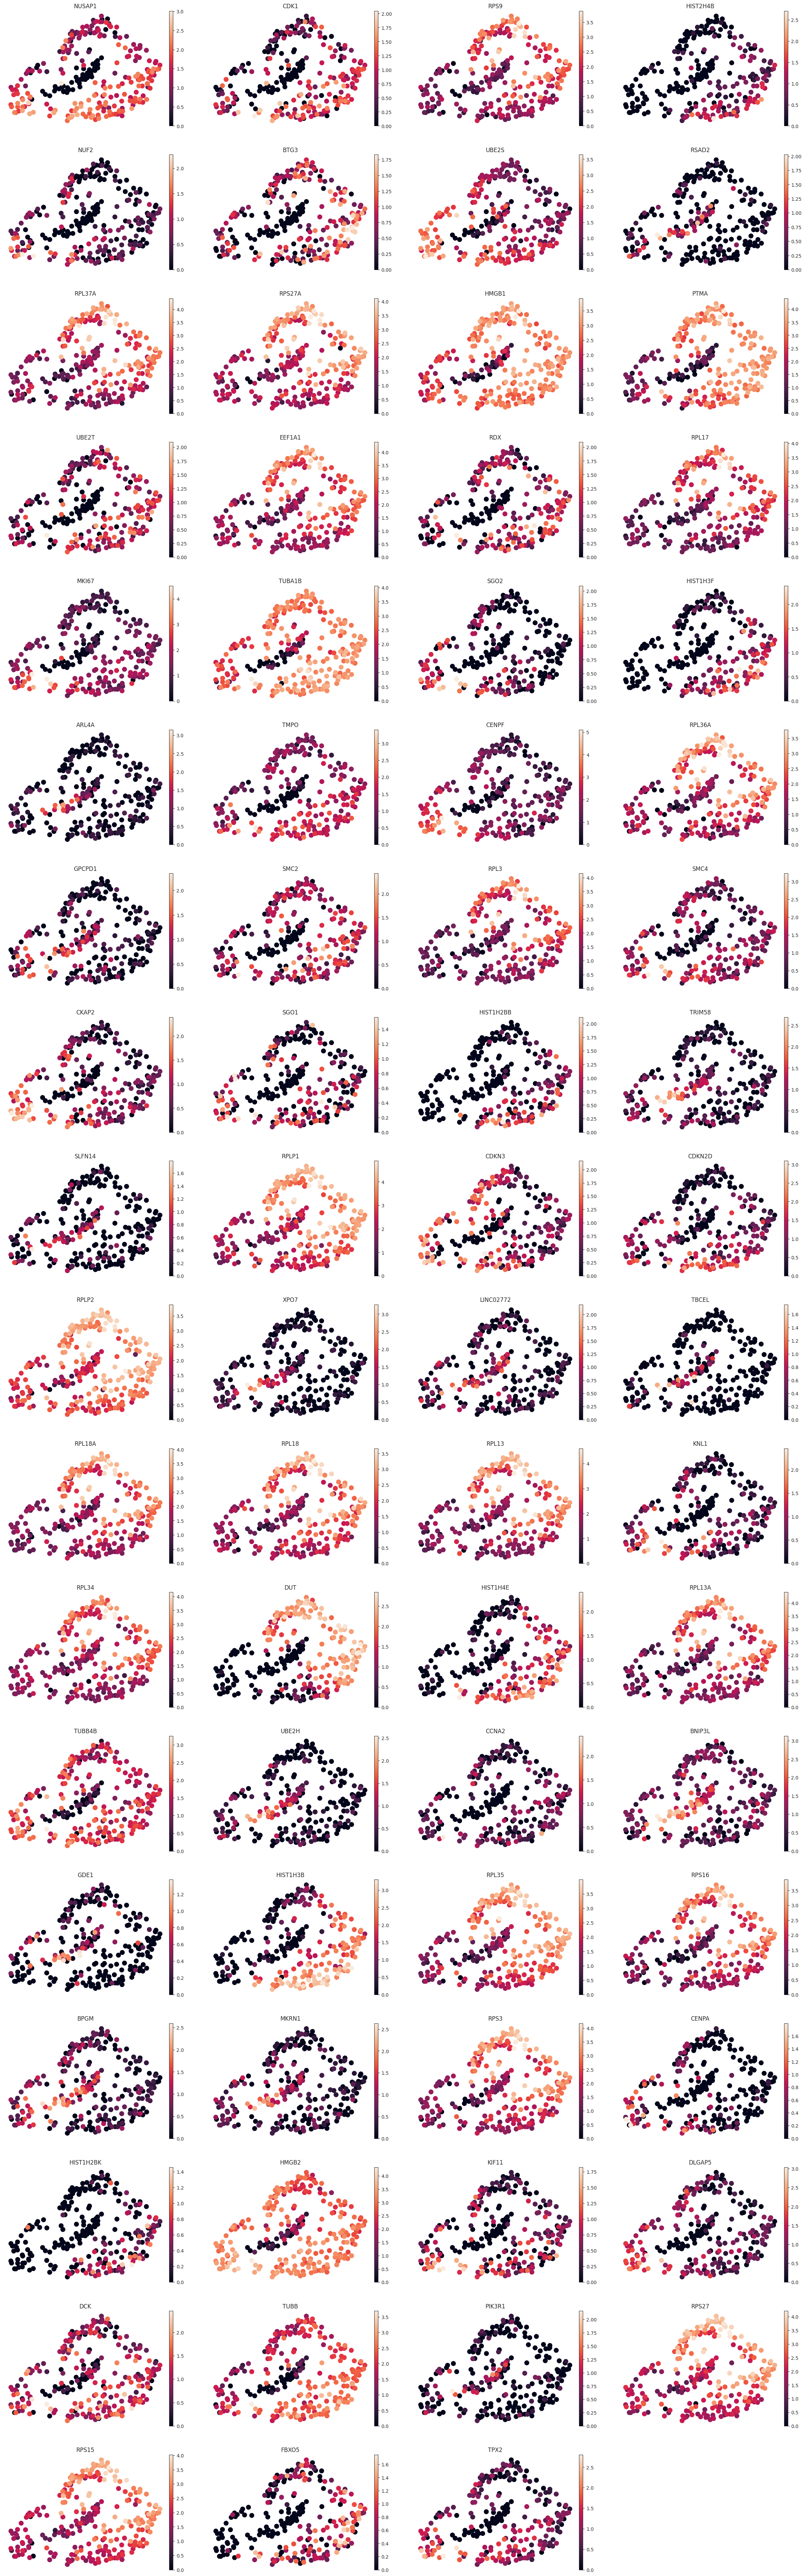

In [42]:
sc.pl.umap(filtered_adata, color=['NUSAP1', 'CDK1', 'RPS9', 'HIST2H4B', 'NUF2', 'BTG3', 'UBE2S', 'RSAD2', 'RPL37A', 'RPS27A', 'HMGB1', 'PTMA', 'UBE2T', 'EEF1A1', 'RDX', 'RPL17', 'MKI67', 'TUBA1B', 'SGO2', 'HIST1H3F', 'ARL4A', 'TMPO', 'CENPF', 'RPL36A', 'GPCPD1', 'SMC2', 'RPL3', 'SMC4', 'CKAP2', 'SGO1', 'HIST1H2BB', 'TRIM58', 'SLFN14', 'RPLP1', 'CDKN3', 'CDKN2D', 'RPLP2', 'XPO7', 'LINC02772', 'TBCEL', 'RPL18A', 'RPL18', 'RPL13', 'KNL1', 'RPL34', 'DUT', 'HIST1H4E', 'RPL13A', 'TUBB4B', 'UBE2H', 'CCNA2', 'BNIP3L', 'GDE1', 'HIST1H3B', 'RPL35', 'RPS16', 'BPGM', 'MKRN1', 'RPS3', 'CENPA', 'HIST1H2BK', 'HMGB2', 'KIF11', 'DLGAP5', 'DCK', 'TUBB', 'PIK3R1', 'RPS27', 'RPS15', 'FBXO5', 'TPX2'], frameon=False)

Аннотация датосета по генам белков клеточного цикла

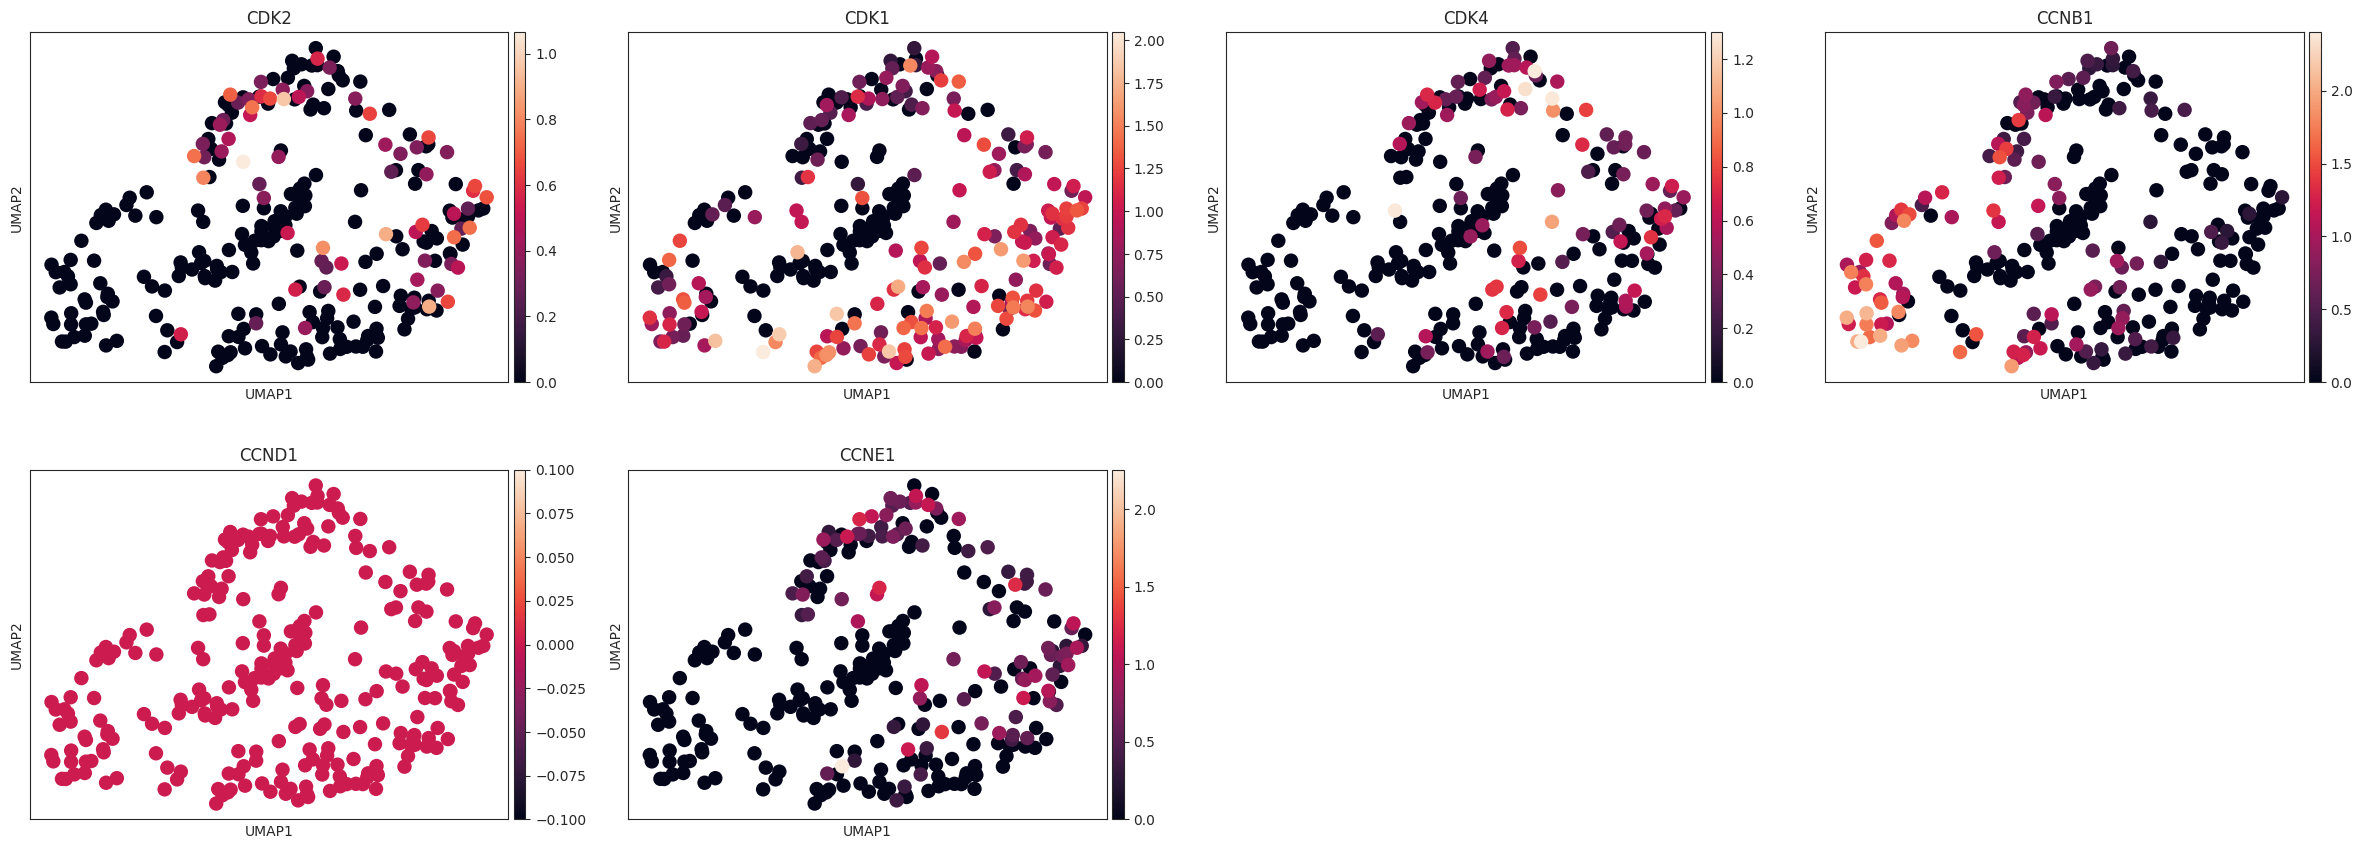

In [43]:
sc.pl.umap(filtered_adata, color=['CDK2', 'CDK1', 'CDK4', 'CCNB1', 'CCND1', 'CCNE1'])

Гены наиболее экспрессируемые в нормобластах

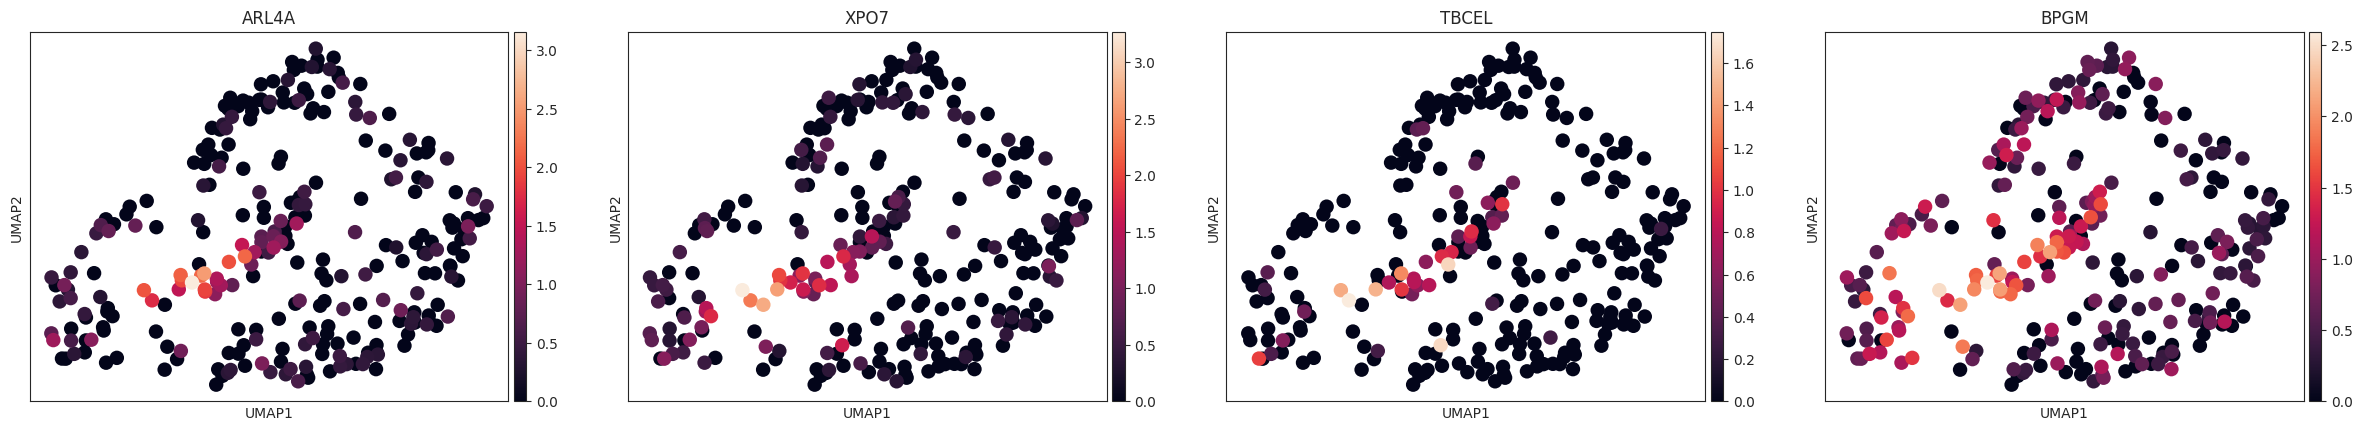

In [44]:
sc.pl.umap(filtered_adata, color=['ARL4A', 'XPO7', 'TBCEL', 'BPGM'])

Гены экспрессируемые в проэритробластах и эритробластах

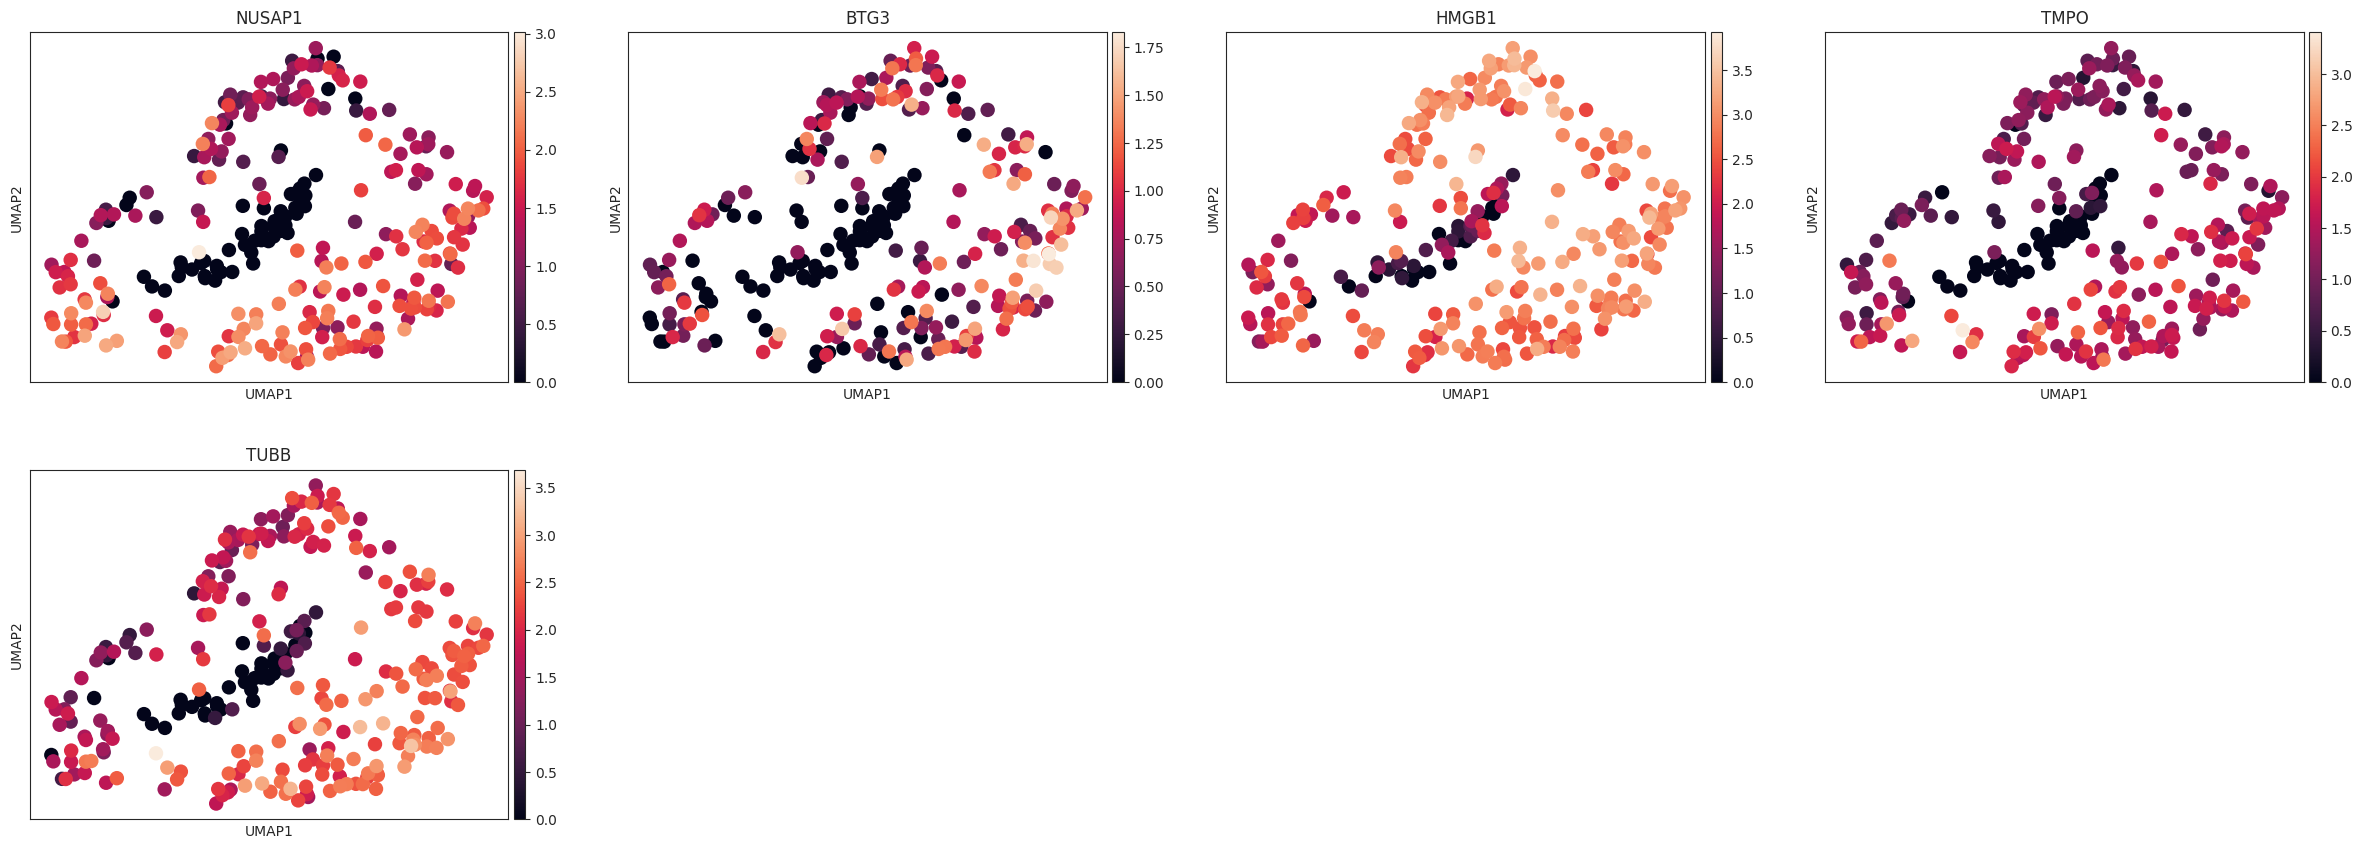

In [45]:
sc.pl.umap(filtered_adata, color=['NUSAP1', 'BTG3', 'HMGB1', 'TMPO', 'TUBB'])

Гены экспрессируемые во всём датосете

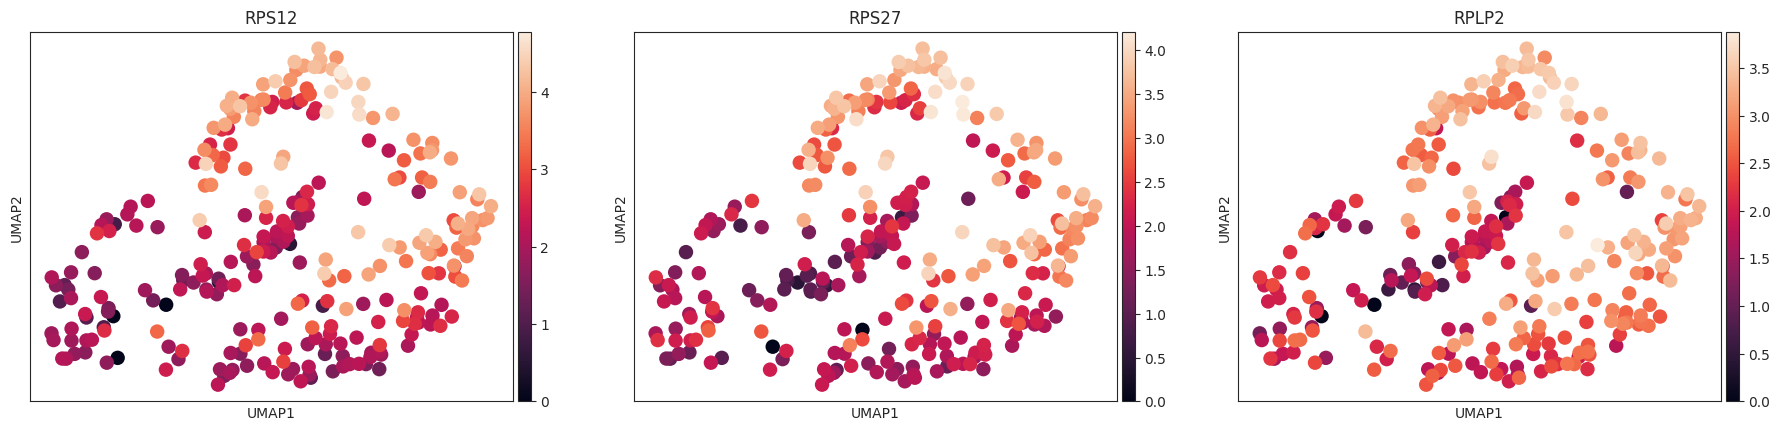

In [48]:
sc.pl.umap(filtered_adata, color=['RPS12', 'RPS27', 'RPLP2'])

Особые случаи

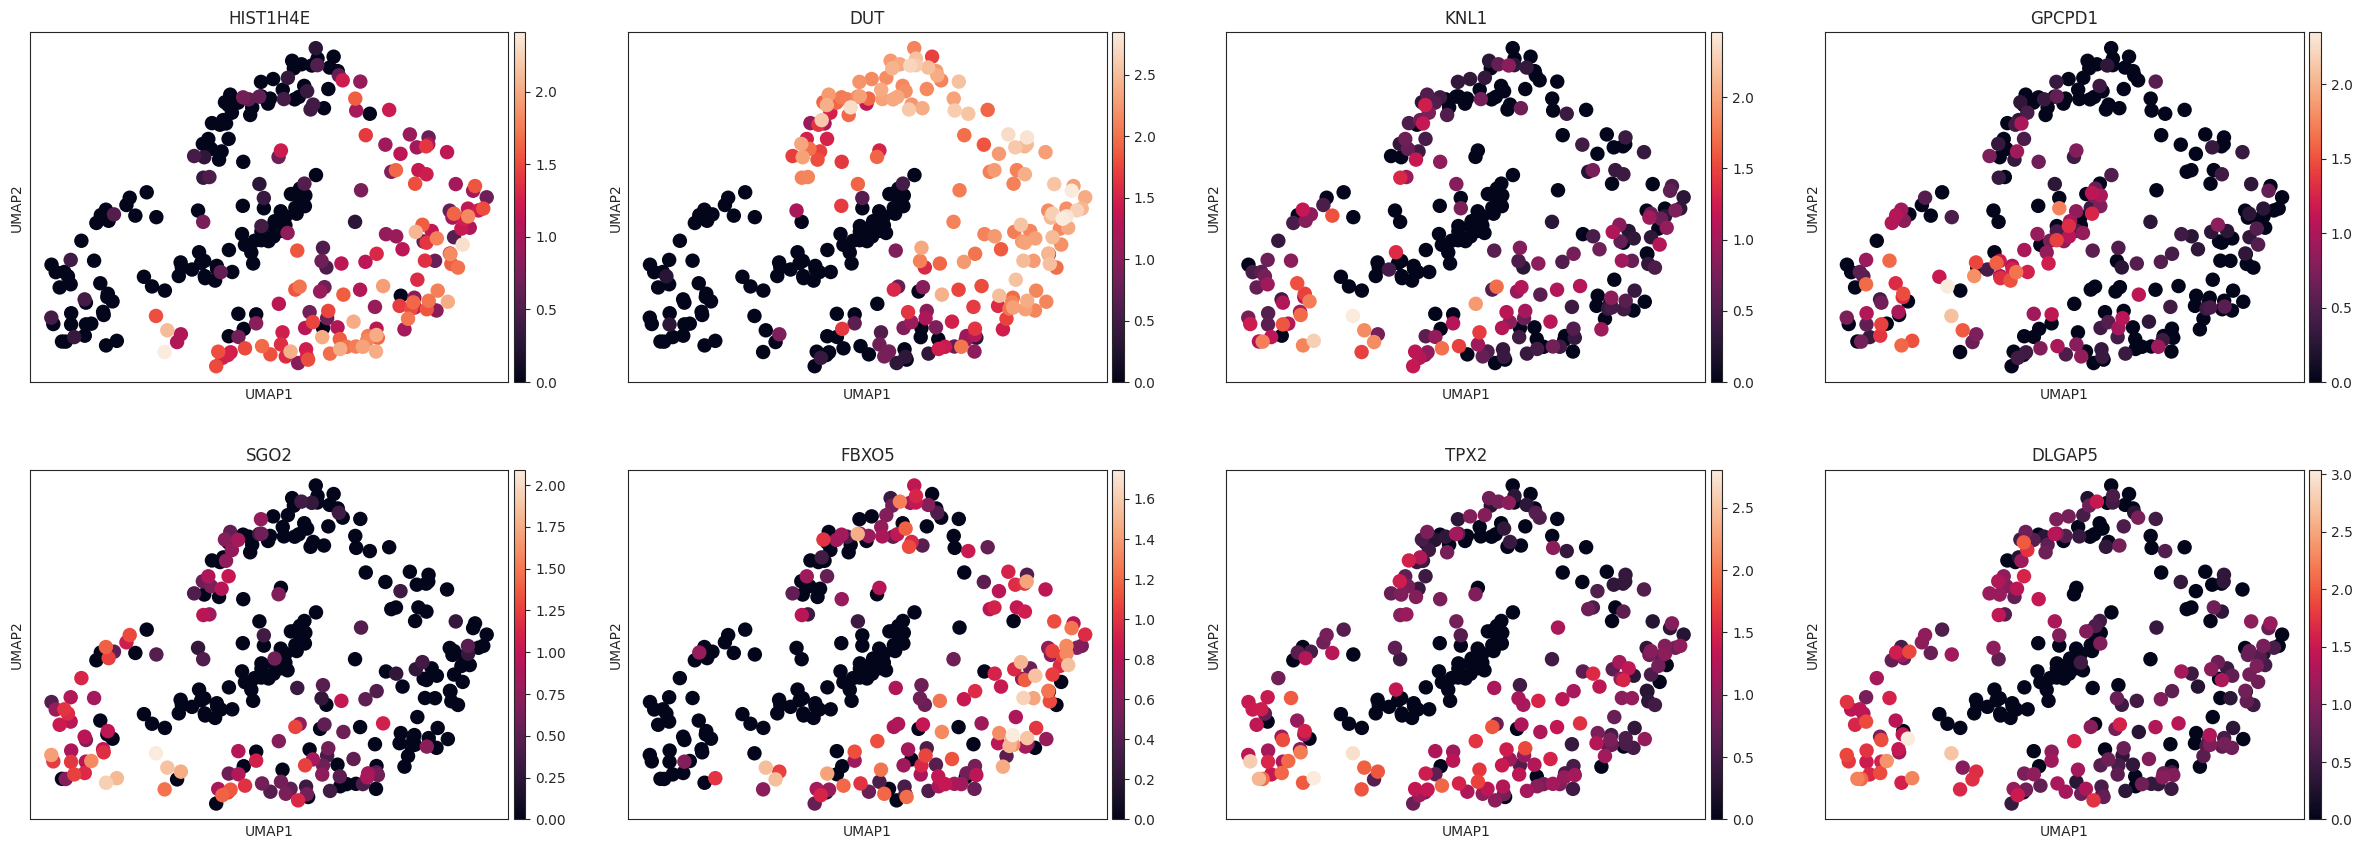

In [50]:
sc.pl.umap(filtered_adata, color=['HIST1H4E', 'DUT', 'KNL1', 'GPCPD1', 'SGO2', 'FBXO5', 'TPX2', 'DLGAP5'])